### To filter out any potential human DNA from the sample, I ran the following command in the terminal: ###

bowtie2 -p 4 --very-fast --no-unal -x /data/hg19/hg19 -U /data/lab6/illumina_reads.fastq 
             -S hdna_output.sam --un filtered_mr1dna.fastq 

### This returned the following:

1124714 reads; of these:<br/>
  1124714 (100.00%) were unpaired; of these:<br/>
    1028379 (91.43%) aligned 0 times<br/>
    87274 (7.76%) aligned exactly 1 time<br/>
    9061 (0.81%) aligned >1 times<br/>
8.57% overall alignment rate

If this worked as intended then _hdna_ _ _output.sam_ should contain all of the reads that matched up to the human genome it was ran against, and _filtered_ _ _mr1dna.fastq_ (the --un unaligned.fastq option) should contain little-to-no human DNA and is hopefully only DNA extracted from S. oneidensis. Accoring to the output from the bowtie2 alignment **8.57%** of the DNA aligned with the human genome, and therefore consituted the fraction of contaminant DNA.

### Running the filtered DNA sample against the S. oneidensis MR-1 reference genome:

bowtie2 -p 4 --very-fast --no-unal -x /data/lab6/shewanella_oneidensis_mr-1 -U ~/lab/filtered_mr1dna.fastq -S mr1_aligned.sam --              un mr1_unaligned.fastq

### Which returned:

1028379 reads; of these:<br/> 
  1028379 (100.00%) were unpaired; of these:<br/>
    299560 (29.13%) aligned 0 times<br/>
    687571 (66.86%) aligned exactly 1 time<br/>
    41248 (4.01%) aligned >1 times<br/>
70.87% overall alignment rate

This gives a decent alignment rate, but it is not 100%. Perhaps our reads came from an organism with variants that simply aren't represented in the MR-1 reference genome, or perhaps the bowtie2 algorithm could use more refinement (maybe both?). It is also possible that the samples have other contamination besides the exprimenter's DNA. 

### Let's see if we can get better alignment by adjusting the sensitivity of the alignment algorithm:

bowtie2 -p 4 --very-sensitive --no-unal -x /data/lab6/shewanella_oneidensis_mr-1 -U ~/lab/filtered_mr1dna.fastq -S                            mr1_aligned.sam --un mr1_unaligned.fastq

1028379 reads; of these:<br/>
  1028379 (100.00%) were unpaired; of these:<br/>
    298112 (28.99%) aligned 0 times<br/>
    688180 (66.92%) aligned exactly 1 time<br/>
    42087 (4.09%) aligned >1 times<br/>
71.01% overall alignment rate

The --very-sensitive option did indeed give better alignment, but not much. Still, it is better to use this alighment than the previous. 

### Wait, perhaps we can do better. We should re-filter the original read file using the sensitive algorithm to make sure we really separate out all of the human DNA, and then again try to align our reads to the reference MR-1 with the sensitive algorithm:

bowtie2 -p 4 --very-sensitive --no-unal -x /data/hg19/hg19 -U /data/lab6/illumina_reads.fastq -S sensitive_hdna_out.sam --un sensitive_filtered_mr1dna.fastq

### The output is only slightly different from what we got with the first attempt to filter using the "--very-fast" option:

1124714 reads; of these:<br/>
  1124714 (100.00%) were unpaired; of these:<br/>
    1028330 (91.43%) aligned 0 times<br/>
    86198 (7.66%) aligned exactly 1 time<br/>
    10186 (0.91%) aligned >1 times<br/>
8.57% overall alignment rate

We see a change between the reads that aligned exactly once and those that aligned greater than once. However, the overall alignment rate has no change, and the same ratio of our reads aligned with the human genome, so it does not help us to run these results in attempt to get a truer picture of the alignment of our reads to the reference MR-1 genome. 

### I used the terminal commands from the power point  to convert the SAM to a BAM file and generate the depth tab file

samtools view -b mr1_aligned.sam > mr1_aligned.bam<br/>
samtools sort mr1_aligned.bam > mr1_aligned.sorted.bam<br/>
samtools index mr1_aligned.sorted.bam<br/>
samtools depth -a mr1_aligned.sorted.bam > pileup.tab

### I used PSCP to transfer the pileup.tab file from the remote to my local machine:

\>pscp be131-16@bioe131.com:/home/be131-16/mr1_aligned_pileup.tab C:\Users\cms\Desktop


### Now we use Pandas to parse the tab file and we'll get an array where columns 1 & 2 are the position in the genome and the position coverage respectively

In [69]:
import pandas as pd 
import numpy as np
import statistics

%pylab inline


Populating the interactive namespace from numpy and matplotlib


In [39]:
depth = pd.read_csv('mr1_aligned_pileup.tab', header=None, sep='\t')

position = depth[1].values.ravel()

coverage = depth[2].values.ravel()

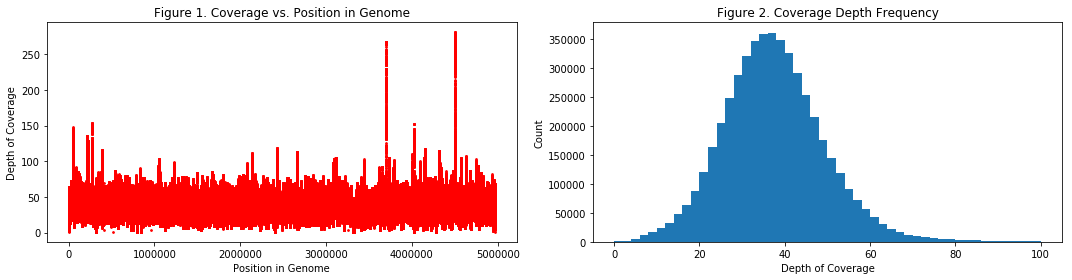

In [55]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.scatter(position, coverage, s=3, color='red')
plt.title('Figure 1. Coverage vs. Position in Genome')
plt.xlabel('Position in Genome')
plt.ylabel('Depth of Coverage')


plt.subplot(1,2,2)
plt.hist(coverage, range=[0,100], bins=50)
plt.title('Figure 2. Coverage Depth Frequency')
plt.xlabel('Depth of Coverage')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [72]:
print("The minimum coverage for a position is:", min(depth[2]))
print("The maximum coverage for a position is:", max(depth[2]))
print("The mean coverage for a position is:", int(round(mean(depth[2]))))

The minimum coverage for a position is: 1
The maximum coverage for a position is: 281
The mean coverage for a position is: 37


### From the scatterplot we can see the coverage was much higher for a few positions in the genome. 